In [6]:
import numpy as np
import tensorflow as tf

# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 

from datetime import datetime
from packaging import version


import ipysh
import Hunch_utils  as Htls
import Hunch_lsplot as Hplt
import Hunch_tSNEplot as Hsne

%aimport Dataset_QSH
%aimport models.base
%aimport models.AEFIT5
%aimport models.AEFIT8


import livelossplot.keras
class PlotLossesCallback(livelossplot.keras.PlotLossesCallback):
    def on_train_batch_begin(self, a, b): pass
    def on_train_batch_end(self, a, b): pass
    def on_test_begin(self, a): pass
    def on_test_end(self, a): pass
    def on_test_batch_begin(self, a, b): pass
    def on_test_batch_end(self, a, b): pass

In [136]:
qsh = Dataset_QSH.Dataset_QSH()
import os
file = ipysh.abs_builddir+'/te_db_fix_r15_shuffle.npy'
qsh.load(file)


In [137]:
qsh.clean_up_poorcurves(5)
qsh.dim = None
qsh.set_null(np.nan)
# qsh.set_normal_positive()
qsh.set_normal_positive(['prel','te','tcentro','tbordo','Ip','VT','NS'])

print("QSH rebalanced 15 points size: ", len(qsh))

QSH rebalanced 15 points size:  47567


## VAE reconstruction - beta

The dropout has been set to 0. ... otherwise it seems to not converge ( tested with 0.4 )
Moreover also beta has been set to 0. ... that corresponds to a deterministic vae

In [138]:
vae  = models.AEFIT8.AEFIT8(latent_dim=6, feature_dim=35, dprate=0., scale=1, beta=0.0, geometry=[20,20,10,10])

AEFIT8 ready:


In [139]:
def _map(x,y):
    return tf.concat([x,y],axis=0)

ds = qsh.tf_tuple_compose(['prel~te:15','tcentro~tbordo~Ip~VT~NS']).map(lambda x,y: (_map(x,y),_map(x,y)))
[x for x in ds.take(10)][0]

(<tf.Tensor: id=2282556, shape=(35,), dtype=float32, numpy=
 array([       nan, 0.10277789, 0.15121816, 0.20828514, 0.27427357,
        0.3485927 , 0.42948723, 0.51404023, 0.59859335, 0.6794879 ,
        0.75380695,        nan,        nan,        nan,        nan,
               nan, 0.47085014, 0.4789356 , 0.44991535, 0.49600562,
        0.4603666 , 0.46113756, 0.4934741 , 0.46349722, 0.48122364,
        0.6778591 ,        nan,        nan,        nan,        nan,
        0.59479386, 0.        , 0.49982342, 0.40706033, 0.23043942],
       dtype=float32)>,
 <tf.Tensor: id=2282557, shape=(35,), dtype=float32, numpy=
 array([       nan, 0.10277789, 0.15121816, 0.20828514, 0.27427357,
        0.3485927 , 0.42948723, 0.51404023, 0.59859335, 0.6794879 ,
        0.75380695,        nan,        nan,        nan,        nan,
               nan, 0.47085014, 0.4789356 , 0.44991535, 0.49600562,
        0.4603666 , 0.46113756, 0.4934741 , 0.46349722, 0.48122364,
        0.6778591 ,        nan,        

In [140]:
class Emedding(tf.keras.callbacks.Callback):
    
    def __init__(self, logdir, validation_data):
        self.logdir = logdir
        self.data = validation_data        
    def set_model(self, model):
        m,v = model.encode(self.data)
        z = model.reparametrize(m,v)
        self.V = tf.Variable(z, trainable=False)
        self.ckpt = tf.train.Checkpoint(V=self.V)

        self.model = model
    def on_epoch_end(self, logs, epoch):
        model = self.model
        m,v = model.encode(self.data)
        z = model.reparametrize(m,v)
        self.V.assign(z)
        self.ckpt.save(self.logdir+'/vae.ckpt')
        



In [141]:
import io

logdir = models.base.create_logdir()
ds_meta = qsh.tf_tuple_compose(['tcentro~tbordo~Ip~VT~NS']).take(3000)

out_v = io.open(logdir+'meta.tsv', 'w', encoding='utf-8')
out_v.write( '\t'.join(['tcentro','tbordo','Ip','VT','NS'])+'\n' )
for v in ds_meta:
    # out_v.write( '\t'.join(str(v)+'\n')
    out_v.write( '\t'.join([str(i) for i in v[0].numpy()])+'\n')
out_v.close()

LOG:  /home/andrea/devel/rfx/rfx-hunch/src/Tprofile_read/jpnb/logs/fit_20200124-100910


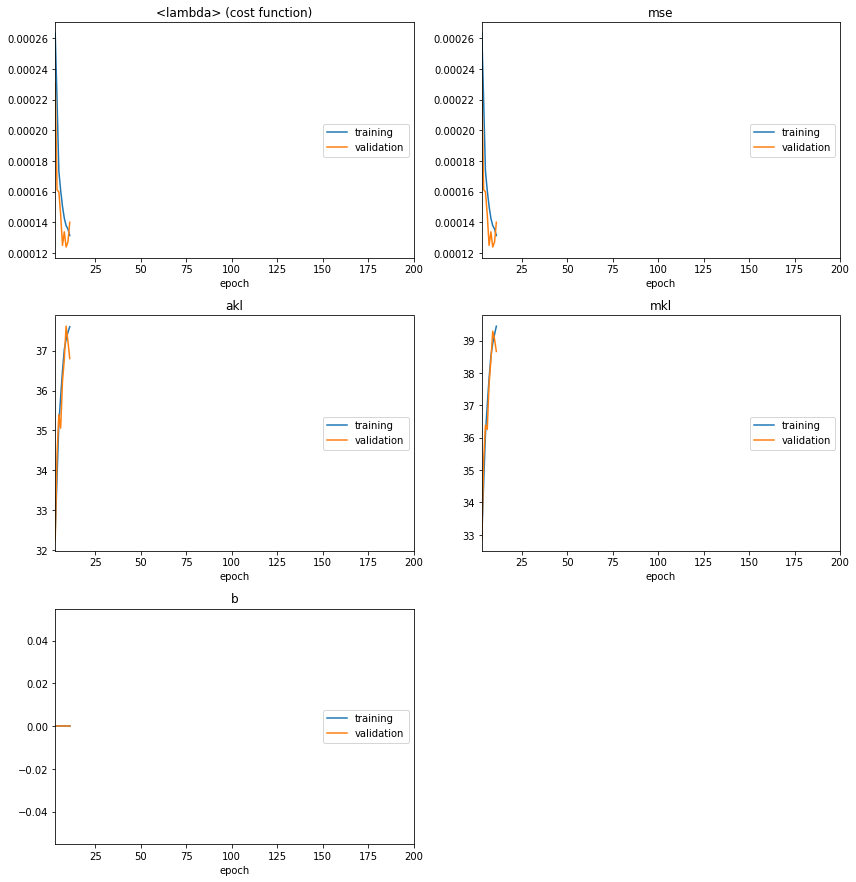

<lambda> (cost function):
training   (min:    0.000, max:    0.004, cur:    0.000)
validation (min:    0.000, max:    0.000, cur:    0.000)

mse:
training   (min:    0.000, max:    0.004, cur:    0.000)
validation (min:    0.000, max:    0.000, cur:    0.000)

akl:
training   (min:   21.884, max:   37.596, cur:   37.596)
validation (min:   30.883, max:   37.609, cur:   36.799)

mkl:
training   (min:   21.791, max:   39.447, cur:   39.447)
validation (min:   30.535, max:   39.290, cur:   38.666)

b:
training   (min:    0.000, max:    0.000, cur:    0.000)
validation (min:    0.000, max:    0.000, cur:    0.000)
445/445 [==============================] - 8s 19ms/step - loss: 1.3097e-04 - mse: 1.3136e-04 - akl: 37.5961 - mkl: 39.4474 - b: 0.0000e+00 - val_loss: 1.4001e-04 - val_mse: 1.4001e-04 - val_akl: 36.7989 - val_mkl: 38.6659 - val_b: 0.0000e+00
Epoch 12/200
28/30 [===========================>..] - ETA: 0s - loss: 1.2863e-04 - mse: 1.2863e-04 - akl: 36.7240 - mkl: 38.6296 - b: 0.0000

In [142]:
#models.base.manual_train_thread(q_vae, qsh, batch=200, epoch=6, loss_factor=1e-3)
# q_vae.train_thread(qsh, batch=200, epoch=10, learning_rate=1e-3).control_panel()
# models.base.train_thread(q_vae, qsh, batch=100, epoch=10, learning_rate=1e-3, callbacks=[]).control_panel()

# import io
# logdir = models.base.create_logdir()

# out_v = io.open(logdir+'meta.tsv', 'w', encoding='utf-8')
# tcentro = qsh['tcentro'][0:3000]
# for c in tcentro:
#     out_v.write(str(c)+'\n')
# out_v.close()

tbcb   = models.base.tensorboard_cb(logdir)

vdata = [x for x in ds.take(3000).batch(3000)][0]

e = Emedding(logdir, vdata)

def fun():
    global h
    h = vae.fit( ds.skip(3000).cache().batch(100, drop_remainder=True), validation_data=ds.take(3000).cache().batch(100), 
                   callbacks=[PlotLossesCallback(),e], 
                   epochs=200, shuffle=False)
models.base.fn_thread(fn=fun, model=vae).control_panel()

In [19]:
loss = [i[0] for i in h.history['loss']]
val_loss = [i[0] for i in h.history['val_loss']]
fig = plt.figure('loss')
fig.set_dpi(150)
plt.yscale('log')
plt.plot(loss[0:150])
plt.plot(val_loss[0:150])

NameError: name 'h' is not defined

In [ ]:
# vae6.load('step7_ls6')

In [33]:
from tensorboard.plugins import projector
import io
%load_ext tensorboard

m = [ vae.encode(i,training=False)[0] for i in ds.batch(100).take(1) ]

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# file_writer = tf.summary.create_file_writer(logdir + "/metrics")
# file_writer.set_as_default()



# config = projector.ProjectorConfig()

# embedding = config.embeddings.add()
# embedding.tensor_name = 'm'
# # Link this tensor to its metadata(Labels) file
# # embedding.metadata_path = metadata

out_v = io.open(logdir+'vecs.tsv', 'w', encoding='utf-8')
out_m = io.open(logdir+'meta.tsv', 'w', encoding='utf-8')



for x in m[0]:
    out_v.write('\t1.0\t'.join([str(v) for v in x.numpy()]) + "\n")

out_v.close()


# Saves a config file that TensorBoard will read during startup.
# projector.visualize_embeddings(tf.summary.FileWriter(logdir), config)

# tf.summary.scalar('m', data=m, step=0)


#     fig = plt.figure()
#     for i in range(1000):
#         c = np.linspace(0,255,)
#         te = qsh['te'][i]
#         plt.plot(te,'-', color=cm(L[i]), linewidth=0.2) 

#     plt.ion()
#     plt.show()


